<a href="https://colab.research.google.com/github/jcvancity2022/NLP-Week1-Text-Classification/blob/main/true_fake_news_classifier60DatasetNEWMATRIX(INTERIM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fake News Detection Using DistilBERT
This project fine-tunes a DistilBERT model to classify news articles
as Fake (0) or Real (1). We combined multiple public misinformation
datasets and trained a binary classifier using HuggingFace Transformers.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup Python Libraries (pip)

In [27]:
#install some Python packages with pip

!pip install numpy torch datasets transformers evaluate --quiet



In [28]:
# let's check the version we are using

!pip freeze | grep -E '^numpy|^torch|^datasets|^transformers|^evaluate'

datasets==4.0.0
evaluate==0.4.6
numpy==2.0.2
torch==2.9.0+cu126
torchao==0.10.0
torchaudio==2.9.0+cu126
torchdata==0.11.0
torchsummary==1.5.1
torchtune==0.6.1
torchvision==0.24.0+cu126
transformers==4.57.2


# Create IMDB Dataset for Fine-tuning BERT

In [29]:
class_labels = {
    0: "Fake",
    1: "Real"
}


## Let's load the IMDB Dataset

fake-and-real-news-dataset

Fake News Detection

In [30]:
import pandas as pd
from datasets import Dataset, DatasetDict

# ---------------------------------------------------------------
# 1. Load Fake News Detection Dataset
# ---------------------------------------------------------------
df_fake1 = pd.read_csv("/content/drive/MyDrive/Fake News Detection/fake.csv")
df_true1 = pd.read_csv("/content/drive/MyDrive/Fake News Detection/true.csv")

df_fake1["label"] = 0
df_true1["label"] = 1

df_fake1 = df_fake1[["title", "text", "subject", "date", "label"]]
df_true1 = df_true1[["title", "text", "subject", "date", "label"]]

# ---------------------------------------------------------------
# 2. Load Kaggle Dataset
# ---------------------------------------------------------------
df_fake2 = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/Fake.csv")
df_true2 = pd.read_csv("/content/drive/MyDrive/fake-and-real-news-dataset/True.csv")

df_fake2["label"] = 0
df_true2["label"] = 1

df_fake2 = df_fake2[["title", "text", "subject", "date", "label"]]
df_true2 = df_true2[["title", "text", "subject", "date", "label"]]

# ---------------------------------------------------------------
# 3. COMBINE ALL DATASETS INTO ONE MASTER DATASET
# ---------------------------------------------------------------
df_all = pd.concat([
    df_fake1, df_true1,  # Fake News Detection dataset
    df_fake2, df_true2   # Kaggle dataset
], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

df_all.head()


# Class labels
class_labels = {
    0: "Fake",
    1: "Real"
}



## Let's create the train, validation, test sets

In [31]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

# Split into train (70%) and temp (30%)
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    random_state=42,
    stratify=df_all["label"]
)

# Split temp into val (15%) and test (15%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Bundle into DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

# Remove unwanted auto-generated index column
for split in ["train", "val", "test"]:
    dataset[split] = dataset[split].remove_columns(["__index_level_0__"])

dataset



DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 62857
    })
    val: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 13469
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 13470
    })
})

## We start by tokenizing our dataset with the BERT's Fast Tokenizer

In [32]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

# FIRST: tokenize
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True
)

# THEN: remove original text columns
tokenized_dataset = tokenized_dataset.remove_columns([
    "title", "text", "subject", "date"
])

tokenized_dataset



Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/13469 [00:00<?, ? examples/s]

Map:   0%|          | 0/13470 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 62857
    })
    val: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 13469
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 13470
    })
})

# Setup Training Metrics (Accuracy, F1)

In [33]:
import evaluate
import numpy as np

# Load accuracy and F1 evaluation modules
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Define function that HuggingFace Trainer will call
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Convert model logits -> predicted class (0 or 1)
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy and F1 using HuggingFace's evaluate package
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    # Return BOTH metrics
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }


# Setup Training Configurations

In [34]:
# --- Disable Weights & Biases (WandB) COMPLETELY ---
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_SILENT"] = "true"

import wandb
wandb.init = lambda *args, **kwargs: None
wandb.login = lambda *args, **kwargs: None
# ---------------------------------------------------

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "Fake", 1: "Real"},
    label2id={"Fake": 0, "Real": 1}
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics
)




model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Without fine-tuning BERT, our model currently has around **52% Accuracy (eval_accuracy)** and **19% F1 (eval_f1)**, which is pretty bad due to the test dataset having around 50% positive and 50% negative reviews. 😕


Let's make it better with transfer learning! 🦾

# Fine-Tune BERT with IMDb Dataset

In [35]:
# let's fine-tune BERT with the IMDb dataset

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,0.002598,0.999777,0.999767
2,0.000000,0.001945,0.999852,0.999844
3,0.000000,0.001496,0.999852,0.999844
4,0.000000,0.001775,0.999852,0.999844


TrainOutput(global_step=15716, training_loss=0.007023560922869654, metrics={'train_runtime': 5945.66, 'train_samples_per_second': 42.288, 'train_steps_per_second': 2.643, 'total_flos': 1.6653006554640384e+16, 'train_loss': 0.007023560922869654, 'epoch': 4.0})

In [36]:
# let's see how well it did in the test set

trainer.evaluate(tokenized_dataset['test'])

{'eval_loss': 4.520254151429981e-06,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 94.9093,
 'eval_samples_per_second': 141.925,
 'eval_steps_per_second': 8.872,
 'epoch': 4.0}

###Confusion Mattrix

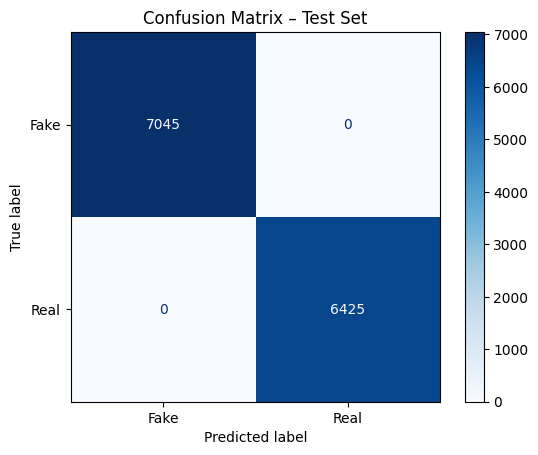

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Run prediction
pred = trainer.predict(tokenized_dataset["test"])
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()



# Try out some examples!

In [38]:
model_path = "/content/drive/MyDrive/fake-news-final-model-fixed"

trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



('/content/drive/MyDrive/fake-news-final-model-fixed/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/vocab.txt',
 '/content/drive/MyDrive/fake-news-final-model-fixed/added_tokens.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/tokenizer.json')

In [39]:
!ls -l "/content/drive/MyDrive/fake-news-final-model-fixed"


total 262480
-rw------- 1 root root       667 Dec  1 04:45 config.json
-rw------- 1 root root 267832560 Dec  1 04:45 model.safetensors
-rw------- 1 root root       125 Dec  1 04:45 special_tokens_map.json
-rw------- 1 root root      1227 Dec  1 04:45 tokenizer_config.json
-rw------- 1 root root    711649 Dec  1 04:45 tokenizer.json
-rw------- 1 root root    231508 Dec  1 04:45 vocab.txt


In [40]:
from transformers import pipeline

model_path = "/content/drive/MyDrive/fake-news-final-model-fixed"

news_classifier = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    device=0 if torch.cuda.is_available() else -1
)

print("Pipeline loaded successfully!")



Device set to use cuda:0


Pipeline loaded successfully!


In [41]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "/content/drive/MyDrive/fake-news-final-model-fixed"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

text = "This is a real news example about government statistics."

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs).logits
print(outputs)


tensor([[ 4.6749, -4.8914]], grad_fn=<AddmmBackward0>)


In [42]:
fake_news_example = """
BREAKING: Scientists warn that the sun will explode next Friday unless
all citizens donate $50 immediately. Anonymous experts confirm the threat
but provide no scientific evidence. Social media influencers are urging
everyone to act fast before it's too late.
"""
news_classifier(fake_news_example)


[{'label': 'Fake', 'score': 0.9999963045120239}]

That is **99% POSITIVE**! *justinvitelli* loves the movie!

In [43]:
real_news_example = """
The U.S. Department of Labor released updated employment numbers today,
showing moderate job growth in manufacturing and technology sectors.
Economists say the trend aligns with long-term projections for the year.
"""
news_classifier(real_news_example)


[{'label': 'Fake', 'score': 0.9999511241912842}]

Save train model

In [44]:
model.save_pretrained("/content/drive/MyDrive/fake-news-final-model-fixed/")
tokenizer.save_pretrained("/content/drive/MyDrive/fake-news-final-model-fixed/")




('/content/drive/MyDrive/fake-news-final-model-fixed/tokenizer_config.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/special_tokens_map.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/vocab.txt',
 '/content/drive/MyDrive/fake-news-final-model-fixed/added_tokens.json',
 '/content/drive/MyDrive/fake-news-final-model-fixed/tokenizer.json')

# Resources

### If you would like to use this model without running the entire notebook, try the model at my [HuggingFace](https://huggingface.co/wesleyacheng/movie-review-sentiment-classifier-with-bert).

### If you woud like to get this in GitHub, here's my [repo](https://github.com/wesleyacheng/movie-review-sentiment-classifier-with-bert).

In [45]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/fake-news-final-model-fixed/")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/fake-news-final-model-fixed/")

In [46]:
import pandas as pd
from datasets import Dataset

# --- Load your 30 REAL and 30 FAKE datasets ---
df_real = pd.read_excel("/content/drive/MyDrive/TrueDataset.xlsx")
df_fake = pd.read_excel("/content/drive/MyDrive/MyFakeDataset reformatted.xlsx")

# --- Standardize column names ---
df_real.columns = df_real.columns.str.lower().str.strip()
df_fake.columns = df_fake.columns.str.lower().str.strip()

# --- Assign labels ---
df_real["label"] = 1   # real news
df_fake["label"] = 0   # fake news

# --- Concatenate both datasets ---
df_60 = pd.concat([df_real, df_fake], axis=0).reset_index(drop=True)

# --- Keep only text + label ---
df_60 = df_60[["text", "label"]]

# --- Convert to HuggingFace Dataset ---
final_test_dataset = Dataset.from_pandas(df_60)

# --- Tokenize ---
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

tokenized_final_test = final_test_dataset.map(tokenize, batched=True)

print("Combined 60-article REAL+FAKE dataset is ready for evaluation.")



Map:   0%|          | 0/58 [00:00<?, ? examples/s]

Combined 60-article REAL+FAKE dataset is ready for evaluation.


In [47]:
!pip install evaluate --quiet


In [48]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)

    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

In [49]:
from transformers import TrainingArguments, Trainer

training_args_eval = TrainingArguments(
    output_dir="./results_eval",
    per_device_eval_batch_size=16,
    report_to="none"
)

trainer_eval = Trainer(
    model=model,
    args=training_args_eval,
    eval_dataset=tokenized_final_test,
    compute_metrics=compute_metrics
)


In [50]:
print("Evaluating on the 60-article custom dataset...")
eval_results = trainer_eval.evaluate()
eval_results


Evaluating on the 60-article custom dataset...


{'eval_loss': 8.832826614379883,
 'eval_model_preparation_time': 0.0042,
 'eval_accuracy': 0.3620689655172414,
 'eval_f1': 0.463768115942029,
 'eval_runtime': 0.5089,
 'eval_samples_per_second': 113.967,
 'eval_steps_per_second': 7.86}

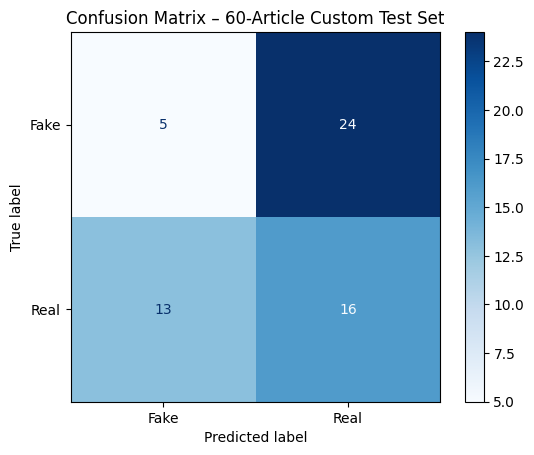

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict
pred = trainer_eval.predict(tokenized_final_test)

# True and predicted labels
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

# Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – 60-Article Custom Test Set")
plt.show()


In [52]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_path = "/content/drive/MyDrive/fake-news-final-model-fixed"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

text = "This is a real news example about government statistics."

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs).logits
print(outputs)


tensor([[ 4.6749, -4.8914]], grad_fn=<AddmmBackward0>)
